In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
import pickle
import os
import time
import datetime
from matplotlib import patches
import multi_tracker_analysis as mta
import scipy.stats
import figurefirst as fifi
import pandas
import copy
import matplotlib.patches as mpatches

from numpy import random, histogram2d, diff
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d

import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats
import scipy.optimize

import flystat # for bootstrapping 95% conf. intervals

/home/caveman/.local/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


1.5.1
recommended version: 1.1.1 or greater


/home/caveman/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Load data

In [5]:
def load_data():
    df = pandas.read_hdf('data/flydata_20210428_3cam.hdf', 'flydata_20210428_3cam')


    minimum_req_visits = 3
    flids_okay = []
    for flid in df.flid.unique():
        dfq = df[df.flid==flid]
        if len(dfq) >= minimum_req_visits:
            flids_okay.append(flid)
    df = df[df.flid.isin(flids_okay)]

    df.fraction_of_time_near_odor += 1e-4 # to help with logs

    # spatial novelty
    new_camera = []
    for ix in range(len(df)):
        nc = 1
        try:
            if df.iloc[ix].flid == df.iloc[ix-1].flid:
                if df.iloc[ix].camera != df.iloc[ix-1].camera:
                    nc = 2
            else:
                nc = 2
        except:
            nc = 2 # first one
        new_camera.append(nc)
    df['new_camera'] = new_camera

    # nth visit
    nth_visit = [1]
    for ix in range(1, len(df)):
        if df.iloc[ix].flid == df.iloc[ix-1].flid:
            nth_visit.append(nth_visit[-1]+1)
        else:
            nth_visit.append(1)
    df['nth_visit'] = nth_visit
    df['log_nth_visit'] = np.log(nth_visit)

    df['mean_interval'] = np.nanmean([df['interval'].values, df['interval2'].values], axis=0)
    df['approached_odor'] = np.sign(df['fraction_of_time_near_odor']-0.001)

    df['camera_num'] = (df['camera'] == 'center_camera')
    df['camera_num'] = (df['camera_num'] -1) /2

    return df

In [21]:
df = load_data()
df = df[ ~ (df.nth_visit==1) ] # drop the first visits for this analysis
df = df[df.interval > 0] # there is one encoutner with a negative interval (and must therefore be mislabelled)

In [34]:
trans_df = pandas.DataFrame()
trans_df['flid'] = df.flid

In [35]:
trans_df['approached_odor'] = df.approached_odor
trans_df['log_search_time'] = np.log(df.search_time)
trans_df['log_distance_travelled'] = np.log(df.distance_travelled)

In [36]:
model = 'log_search_time ~ log_distance_travelled'
print(model)

log_search_time ~ log_distance_travelled


In [37]:
md = smf.ols(model, trans_df)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:        log_search_time   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     372.3
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.29e-43
Time:                        14:15:08   Log-Likelihood:                -174.42
No. Observations:                 162   AIC:                             352.8
Df Residuals:                     160   BIC:                             359.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

In [46]:
mdf.pvalues

Intercept                 5.428136e-01
log_distance_travelled    1.289407e-43
dtype: float64

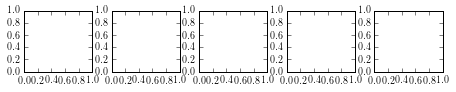

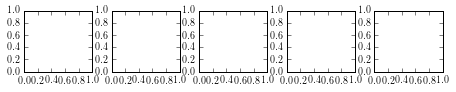

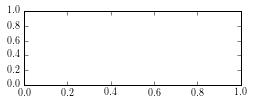

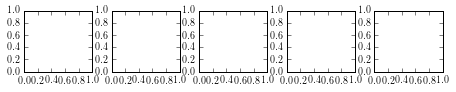

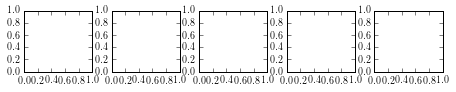

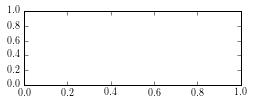

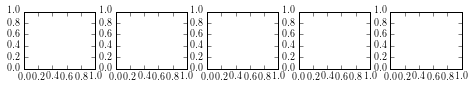

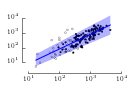

In [45]:
fififig = 'supplemental_figures/foraging_fig_4_revision_supplement.svg'
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax = layout.axes[('time_vs_distance', 'time_vs_distance')]

ax.scatter(trans_df.log_distance_travelled, trans_df.log_search_time, c=trans_df.approached_odor, cmap='bone_r', 
               s=3, linewidth=0.25,rasterized=True)


x = np.linspace(np.min(trans_df.log_distance_travelled.values), np.max(trans_df.log_distance_travelled.values), 100)
y = mdf.params['log_distance_travelled']*x + mdf.params['Intercept']
ax.plot(x, y, color='blue')


if 1:
    input = 'log_distance_travelled'
    # show the confidence interval around the slope and mean
    conf95 = mdf.conf_int(alpha=0.05, cols=None)
    input_coeff_conf_lo = conf95[0][input]
    input_coeff_conf_hi = conf95[1][input]
    
    intercept_conf_lo = conf95[0]['Intercept']
    intercept_conf_hi = conf95[1]['Intercept']
    
    y_hi_hi = input_coeff_conf_hi*x + intercept_conf_hi
    y_hi_lo = input_coeff_conf_hi*x + intercept_conf_lo
    y_lo_hi = input_coeff_conf_lo*x + intercept_conf_hi
    y_lo_lo = input_coeff_conf_lo*x + intercept_conf_lo
    
    y = np.vstack([y_hi_hi, y_hi_lo, y_lo_hi, y_lo_lo])
    y = np.sort(y, axis=0)
    
    ax.fill_between(x, y[0,:], y[-1,:], facecolor='blue', edgecolor='none', alpha=0.3)
    
    
    
yticks = [10**1, 10**2, 10**3, 10**4]
yticklabels = ['$10^{1}$', '$10^2$', '$10^3$', '$10^4$']

xticks = [10**1, 10**2, 10**3, 10**4]
xticklabels = ['$10^{1}$', '$10^2$', '$10^3$', '$10^4$']

fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 yticks=np.log(yticks), 
                                 xticks=np.log(xticks),
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)
ax.minorticks_off()
#ax.set_xlim(np.log(10**1), np.log(10**4))

#fifi.mpl_functions.set_fontsize(ax, 8)
#ax.set_xlabel('Interval before landing (sec)')
#ax.set_ylabel('Observed distance travelled$^{*}$ (mm)')

fifi.mpl_functions.set_fontsize(ax.figure, 6)
layout.append_figure_to_layer(layout.figures['time_vs_distance'], 'time_vs_distance', cleartarget=True)
layout.write_svg(fififig)

